In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


Bad key "text.kerning_factor" on line 4 in
D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 1. 加载数据

In [17]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)
        
    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v['capacity'], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1.1 提取所需特征

In [3]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'dataset/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...


D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/C

**或者**

## 1.1 加载已经提取完成的数据

**如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据**

In [5]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('dataset/CALCE.npy', allow_pickle=True)
Battery = Battery.item()

## 1.2 画容量衰减曲线

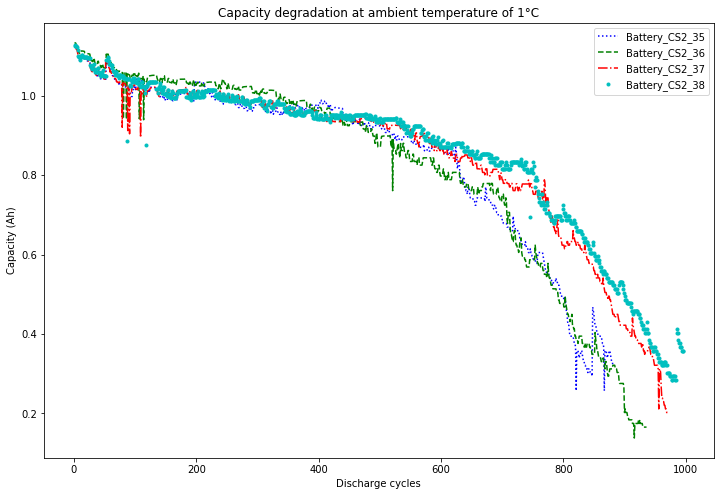

In [6]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

# 2. 建立模型及其训练

## 2.1 建立模型

In [7]:
class Net(nn.Module):
    def __init__(self, hidden_dim=8, num_layers=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
 
    def forward(self, x):           # x shape: (batch_size, feature_size, 1)
        out, _ = self.cell(x)       # out shape: (batch_size, feature_size, hidden_dim)
        out = out[:, -1, :]         # 取序列最后一个时间步的输出作为预测  
        out = self.linear(out)      # out shape: (batch_size, 1)
        return out

## 2.2 训练

In [28]:
def train(lr, feature_size, hidden_dim=64, num_layers=2, weight_decay=0.0, mode='RNN', epochs=100, seed=0, device='cpu', metric='rmse'):
    score_list, result_list = [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        test_x, test_y = build_instances(test_sequence, feature_size)
        # print('sample size: {}'.format(len(train_x)))
        
        model = Net(hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = 1,1
        for epoch in range(epochs):
            X = np.reshape(train_x/Rated_Capacity,(-1, feature_size, 1))   # (batch_size, feature_size, 1)
            y = np.reshape(train_y/Rated_Capacity,(-1,1))          # shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()            
            loss.backward()                    
            optimizer.step()                   

            if (epoch + 1) % 10 == 0:
                x = np.reshape(test_x/Rated_Capacity,(-1, feature_size, 1))
                x = torch.from_numpy(x).to(device) 
                pred = model(x) 
                point_list = pred.data.cpu().numpy() * Rated_Capacity
                point_list = point_list.reshape(-1)
                
                y_.append(point_list)                                 
                loss_list.append(loss)
                rmse = evaluation(y_test=test_y, y_predict=y_[-1])
                re = relative_error(y_test=test_y, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            
            if metric == 're':
                score = [re]
            else:
                score = [rmse]
                
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(train_data.copy()[:-1] + list(y_[-1]))
        
    return score_list, result_list

## 2.3 设置参开始训练

In [24]:
feature_size = 64
epochs = 100
lr = 0.001           # learning rate
hidden_dim = 64
num_layers = 1
weight_decay = 0.0
mode = 'RNN'        # RNN, LSTM, GRU
Rated_Capacity = 1.1
metric = 'rmse'
device = 'cpu'

SCORE = []
for seed in tqdm(range(4)):
    print('seed: ', seed)
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, epochs=epochs, seed=seed, device=device, metric=metric)
    print(np.array(score_list))
    print(metric + ': for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ': mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|          | 0/4 [00:00<?, ?it/s]

seed:  0
[[0.01837623]
 [0.13053122]
 [0.01477865]
 [0.02336097]]
rmse: for this seed: 0.0468
------------------------------------------------------------------
seed:  1
[[0.0362411 ]
 [0.04033594]
 [0.03603044]
 [0.03557413]]
rmse: for this seed: 0.0370
------------------------------------------------------------------
seed:  2
[[0.01458093]
 [0.03992219]
 [0.03411146]
 [0.01407477]]
rmse: for this seed: 0.0257
------------------------------------------------------------------
seed:  3
[[0.0160389 ]
 [0.05345531]
 [0.07402331]
 [0.0365984 ]]
rmse: for this seed: 0.0450
------------------------------------------------------------------
rmse: mean: 0.0386


## 2.4 画预测曲线

**从上面的种子中选择一个表现最好的种子**

In [30]:
seed = 2

feature_size = 64
epochs = 100
lr = 0.001           # learning rate
hidden_dim = 64
num_layers = 1
weight_decay = 0.0
mode = 'RNN'        # RNN, LSTM, GRU
Rated_Capacity = 1.1
metric = 'rmse'
device = 'cpu'

SCORE = []
print('seed: ', seed)
score_list, prediction_list = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                                    weight_decay=weight_decay, mode=mode, epochs=epochs, seed=seed, device=device, metric=metric)

print(np.array(score_list))
print(metric + ' for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))

seed:  2
[[0.01458093]
 [0.03992219]
 [0.03411146]
 [0.01407477]]
rmse for this seed: 0.0257


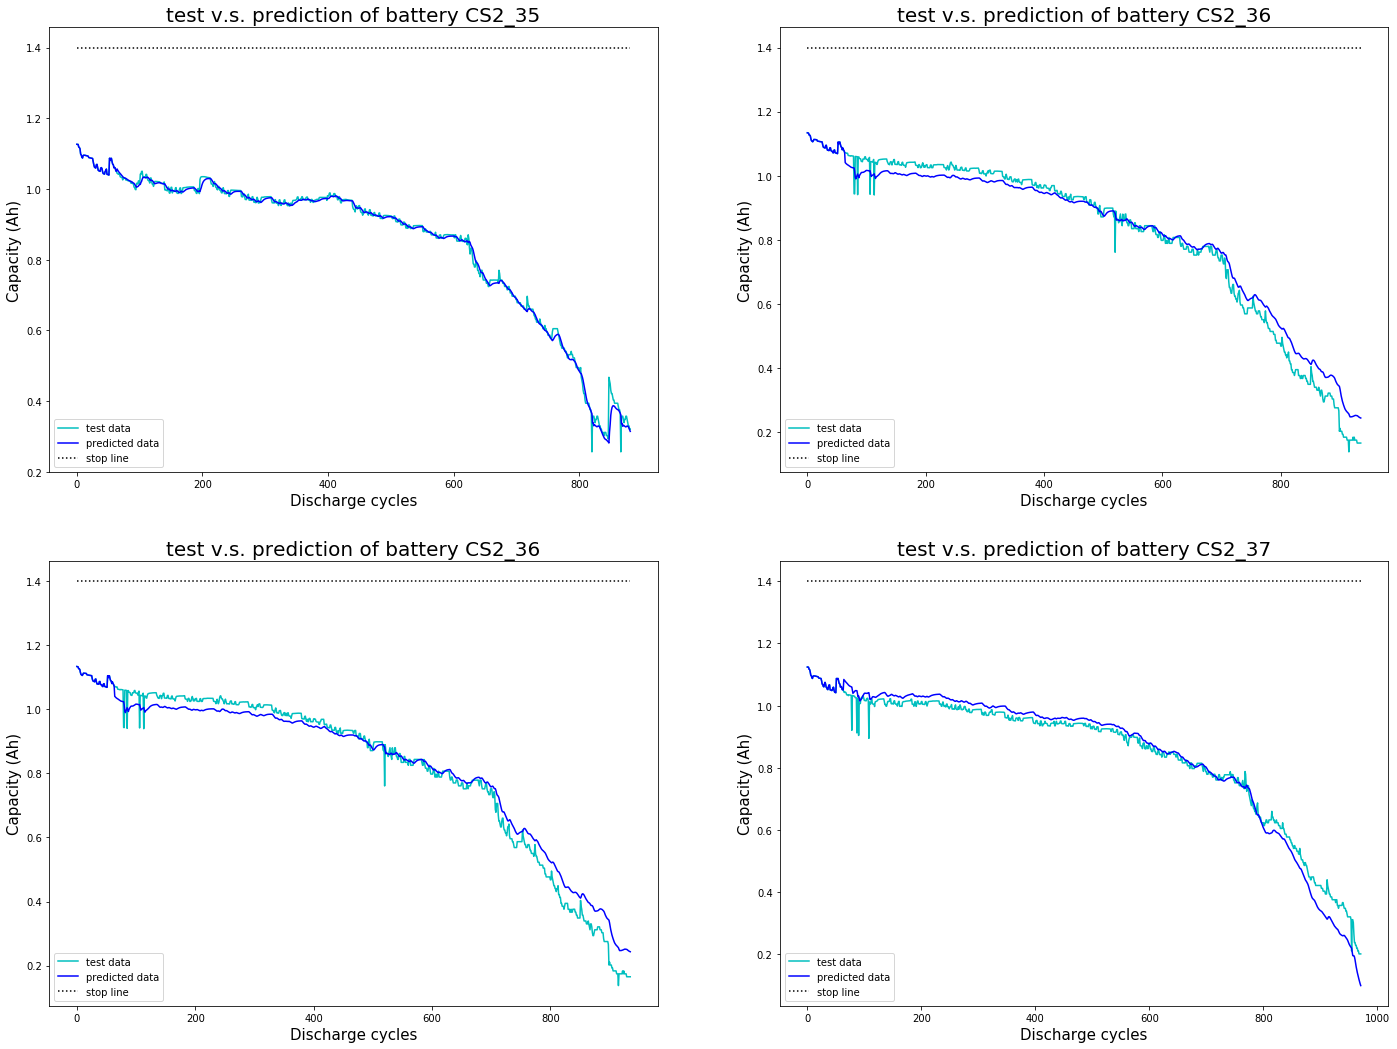

In [31]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name]['capacity']
        predict_data = prediction_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, predict_data, 'b', label='predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()